In [5]:
# pip install
!pip install -r requirements.txt

# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


In [6]:
# Open data file
file_dir = "./assets/A_Z_vol_count-all.txt"
columns = ["Mass Number", "Atomic Number", "Detector Volume", "Counts"]
df = open_data(file_dir, columns)

In [7]:
# Add in isotope data
add_isotope_data(df)
# Reorder columns
df = df[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts", "Detector Volume","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]
df.tail(40)

,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
461,K,K 19-38,19,38,171,11,4.569601e-06,False,4.580000e+02,"[[EC, 1.0, 5.914]]",5.914,red
473,K,K 19-39,19,39,1564147,7,4.179841e-02,True,inf,None,NaN,blue
474,K,K 19-39,19,39,1006313,9,2.689151e-02,True,inf,None,NaN,blue
475,K,K 19-39,19,39,1260609,11,3.368702e-02,True,inf,None,NaN,blue
486,K,K 19-40,19,40,3222,7,8.610090e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red
487,K,K 19-40,19,40,2183,9,5.833590e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red
488,K,K 19-40,19,40,2456,11,6.563123e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red
495,K,K 19-41,19,41,3104910,7,8.297193e-02,True,inf,None,NaN,blue
496,K,K 19-41,19,41,3190032,9,8.524662e-02,True,inf,None,NaN,blue
497,K,K 19-41,19,41,3742022,11,9.999735e-02,True,inf,None,NaN,blue


In [8]:
# Clean unstable isotopes into two datasets
df_unstable = df[df["Stable"] == False]
df_unstable = df_unstable.reset_index()
df_stable = df[df["Stable"] == True]
df_stable = df_stable.reset_index()
print(f"Number of stable isotopes: {len(df) - len(df_unstable)}")
print(f"Number of unstable isotopes: {len(df_unstable)}")
# df_unstable, df_stable

Number of stable isotopes: 125
Number of unstable isotopes: 400


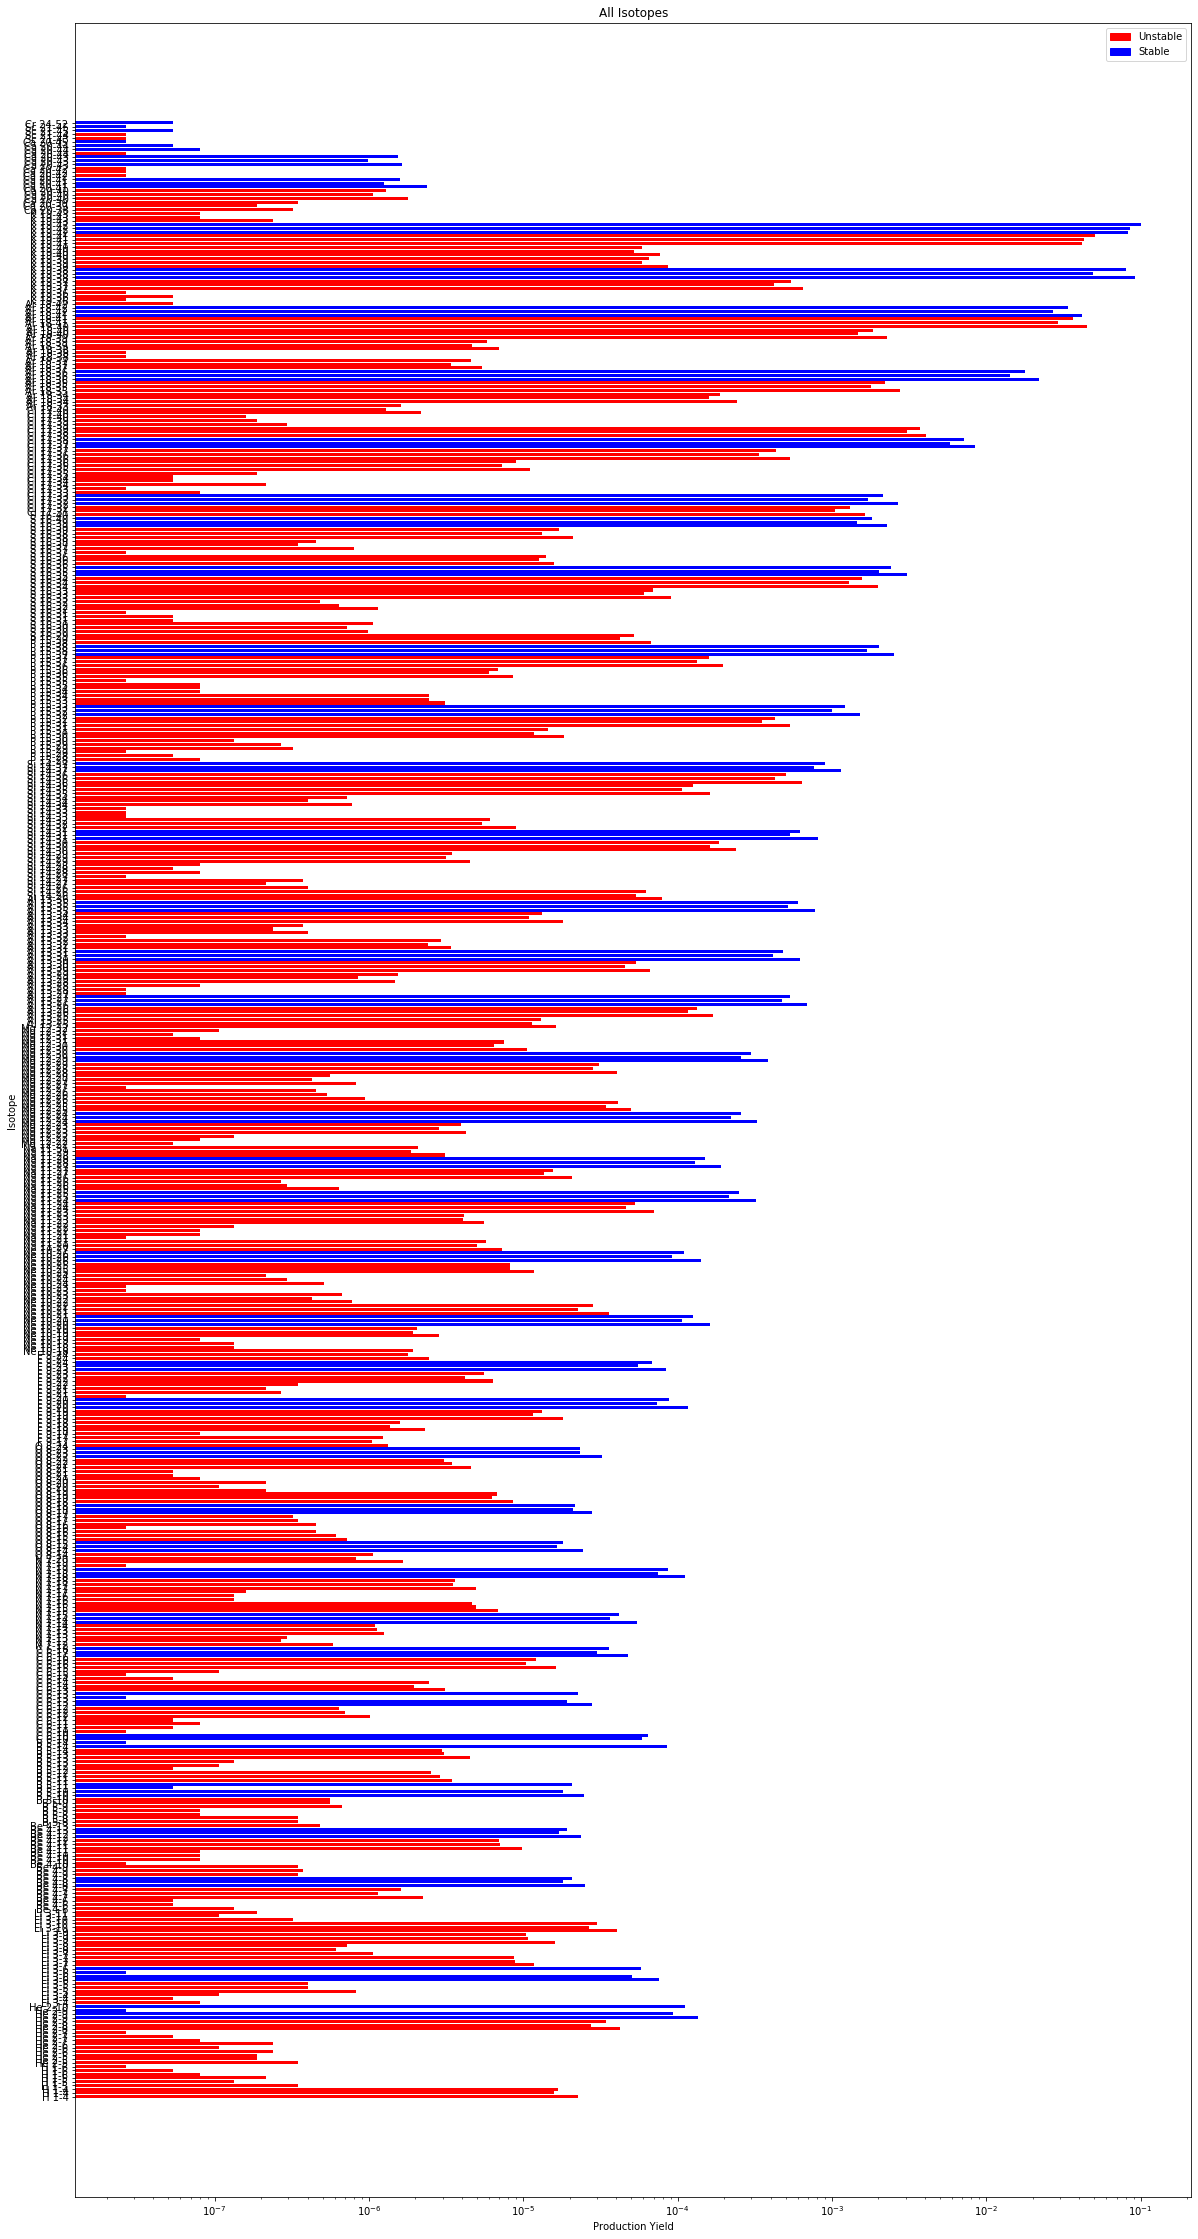

In [9]:
# Plot total
figsize=(20,40)
# Plotting
fig, ax = plt.subplots(figsize=figsize)
ax.barh(df.index, df["Production Yield"], log=True, color=df["Plot Colour"])
ax.set_yticklabels(df["Iso Symbol"])
ax.set_yticks(np.arange(len(df)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax.set_title("All Isotopes")
red_patch = mpatches.Patch(color="red", label="Unstable")
blue_patch = mpatches.Patch(color="blue", label="Stable")
ax.legend(handles=[red_patch, blue_patch], loc=0)
plt.show()

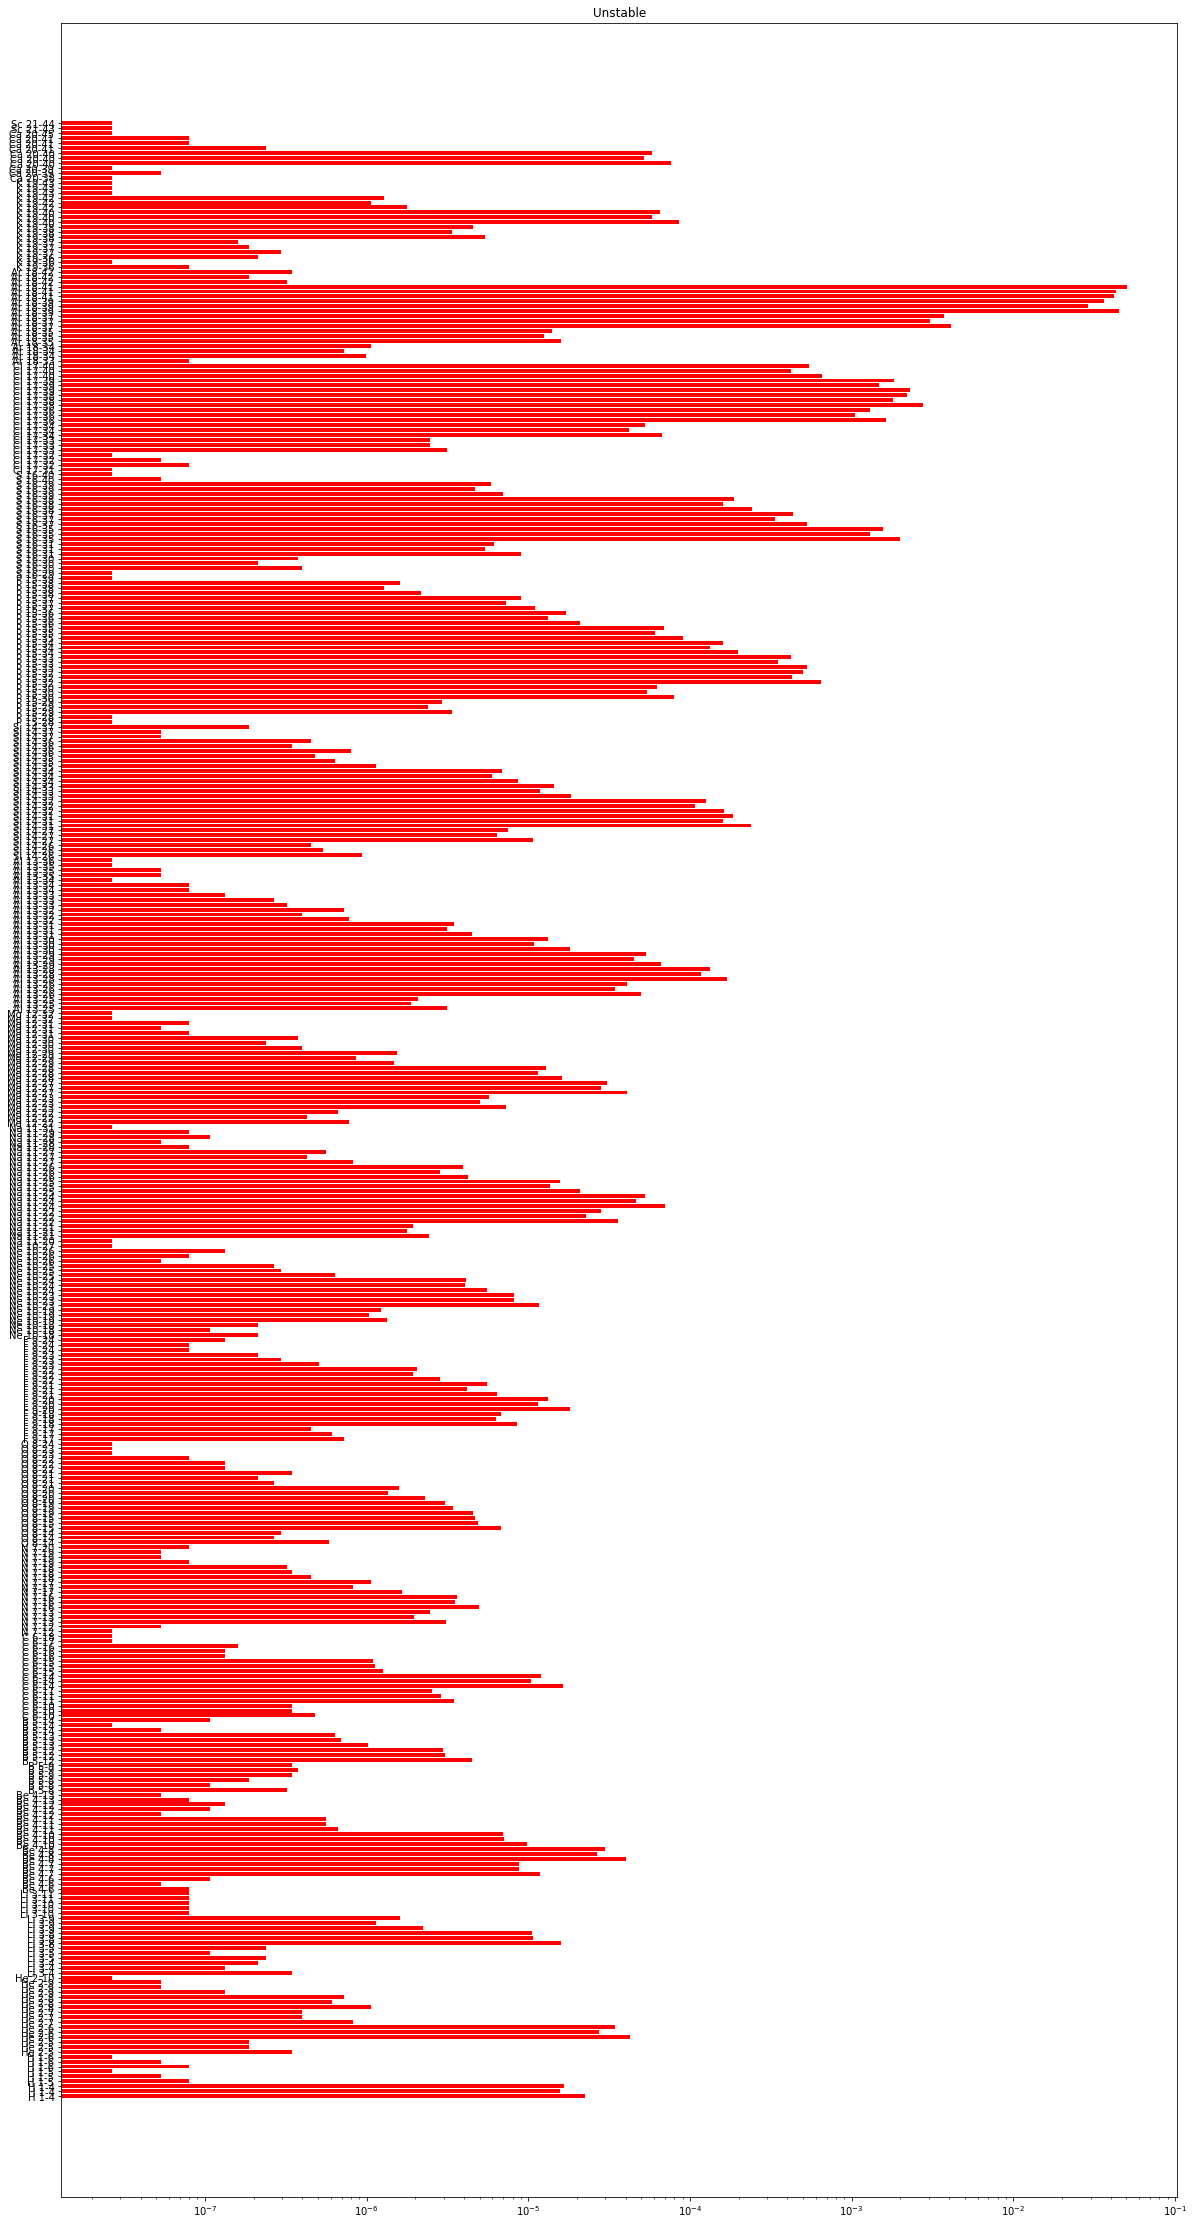

In [10]:
# Plot unstable
fig_un, ax_un = plt.subplots(figsize=figsize)
ax_un.barh(df_unstable.index, df_unstable["Production Yield"], log=True, color=df_unstable["Plot Colour"])
ax_un.set_yticklabels(df_unstable["Iso Symbol"])
ax_un.set_yticks(np.arange(len(df_unstable)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_un.set_title("Unstable")
plt.show()

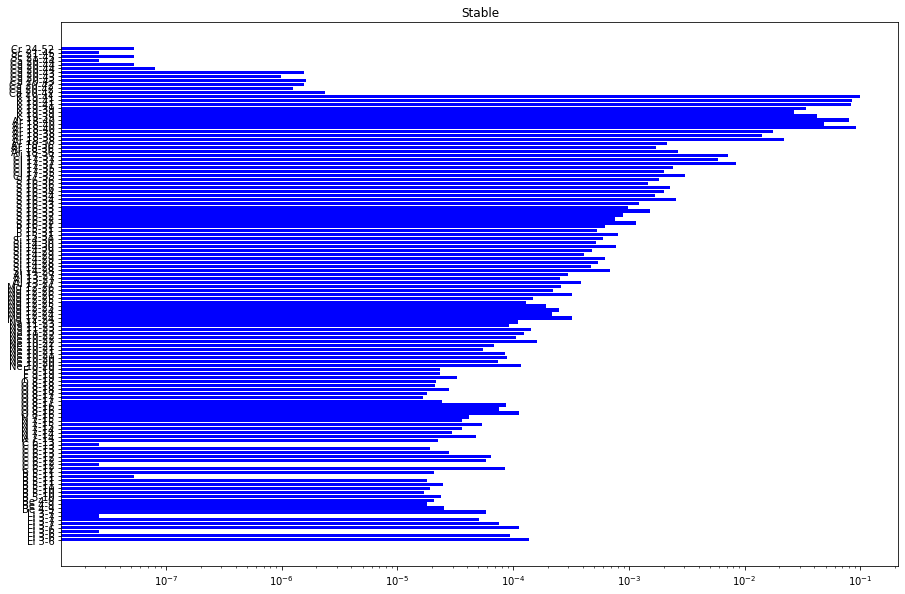

In [11]:
# Plot stable
fig_s, ax_s = plt.subplots(figsize=(15,10))
ax_s.barh(df_stable.index, df_stable["Production Yield"], log=True, color=df_stable["Plot Colour"])
ax_s.set_yticklabels(df_stable["Iso Symbol"])
ax_s.set_yticks(np.arange(len(df_stable)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_s.set_title("Stable")
plt.show()

# Ratio of counts in each volume
key: 7, 9, 11

val: Outer, Inner, TPC

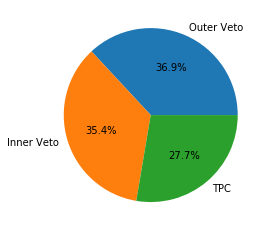

In [12]:
temp_1 = df[df["Detector Volume"] == 7]
temp_3 = df[df["Detector Volume"] == 9]
temp_2 = df[df["Detector Volume"] == 11]
plt.pie(x=[temp_1["Counts"].sum(), temp_2["Counts"].sum(), temp_3["Counts"].sum()], autopct='%1.1f%%', labels=["Outer Veto", "Inner Veto", "TPC"])
plt.show()

# Looking for excess yields

In [13]:
# Sort df by counts
df_count_sort = df.sort_values(["Counts"], ascending=False)
# Try to highlight mass numbers > 40
# df_count_sort.style.apply(lambda x: ["background-color: red" if x["Mass Number"] > 40 else ""], axis = 1)
# Total df
df_count_sort.head(60)

,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
497,K,K 19-41,19,41,3742022,11,0.099997,True,inf,None,NaN,blue
483,Ar,Ar 18-40,18,40,3435858,7,0.091816,True,inf,None,NaN,blue
496,K,K 19-41,19,41,3190032,9,0.085247,True,inf,None,NaN,blue
495,K,K 19-41,19,41,3104910,7,0.082972,True,inf,None,NaN,blue
485,Ar,Ar 18-40,18,40,3007059,11,0.080357,True,inf,None,NaN,blue
494,Ar,Ar 18-41,18,41,1877991,11,0.050185,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
484,Ar,Ar 18-40,18,40,1831550,9,0.048944,True,inf,None,NaN,blue
470,Ar,Ar 18-39,18,39,1680866,7,0.044917,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red
493,Ar,Ar 18-41,18,41,1601006,9,0.042783,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
473,K,K 19-39,19,39,1564147,7,0.041798,True,inf,None,NaN,blue


### Unstable (Counts)
To get a sense of most produced isotopes

In [14]:
# Unstable df sorted by counts
df_count_sort[df_count_sort["Stable"] == False].head(60)

,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
494,Ar,Ar 18-41,18,41,1877991,11,0.050185,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
470,Ar,Ar 18-39,18,39,1680866,7,0.044917,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red
493,Ar,Ar 18-41,18,41,1601006,9,0.042783,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
492,Ar,Ar 18-41,18,41,1558262,7,0.041641,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
472,Ar,Ar 18-39,18,39,1354766,11,0.036203,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red
471,Ar,Ar 18-39,18,39,1081408,9,0.028898,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red
441,Ar,Ar 18-37,18,37,152800,7,0.004083,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red
443,Ar,Ar 18-37,18,37,139509,11,0.003728,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red
442,Ar,Ar 18-37,18,37,114026,9,0.003047,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red
453,Cl,Cl 17-38,17,38,103226,7,0.002758,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red


### Unstable all (heavy (40>))
Any heavy isotopes that may decay

In [15]:
df_unstable[(df_unstable['Mass Number'] > 40)]

,index,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
364,492,Ar,Ar 18-41,18,41,1558262,7,4.164114e-02,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
365,493,Ar,Ar 18-41,18,41,1601006,9,4.278338e-02,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
366,494,Ar,Ar 18-41,18,41,1877991,11,5.018520e-02,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red
367,501,Ar,Ar 18-42,18,42,12,7,3.206737e-07,False,1.040000e+09,"[[B-, 1.0, 0.599]]",0.599,red
368,502,Ar,Ar 18-42,18,42,7,9,1.870597e-07,False,1.040000e+09,"[[B-, 1.0, 0.599]]",0.599,red
369,503,Ar,Ar 18-42,18,42,13,11,3.473966e-07,False,1.040000e+09,"[[B-, 1.0, 0.599]]",0.599,red
382,504,K,K 19-42,19,42,67,7,1.790428e-06,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red
383,505,K,K 19-42,19,42,40,9,1.068912e-06,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red
384,506,K,K 19-42,19,42,48,11,1.282695e-06,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red
385,510,K,K 19-43,19,43,1,7,2.672281e-08,False,8.030000e+04,"[[B-, 1.0, 1.815]]",1.815,red


### Unstable all (Half-life)

In [16]:
df_unstable_sort_life = df_unstable.sort_values("Half Life", ascending=False)
df_unstable_sort_life.head(60)

,index,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
393,491,Ca,Ca 20-40,20,40,2188,11,5.846951e-05,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red
392,490,Ca,Ca 20-40,20,40,1951,9,5.213621e-05,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red
391,489,Ca,Ca 20-40,20,40,2872,7,7.674792e-05,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red
380,487,K,K 19-40,19,40,2183,9,5.833590e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red
379,486,K,K 19-40,19,40,3222,7,8.610090e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red
381,488,K,K 19-40,19,40,2456,11,6.563123e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red
53,68,Be,Be 4-10,4,10,260,11,6.947931e-06,False,4.380000e+13,"[[B-, 1.0, 0.556]]",0.556,red
52,67,Be,Be 4-10,4,10,264,9,7.054822e-06,False,4.380000e+13,"[[B-, 1.0, 0.556]]",0.556,red
51,66,Be,Be 4-10,4,10,365,7,9.753826e-06,False,4.380000e+13,"[[B-, 1.0, 0.556]]",0.556,red
225,264,Al,Al 13-26,13,26,1529,11,4.085918e-05,False,2.260000e+13,"[[EC, 1.0, 4.004]]",4.004,red


# Looking at production yields

### Unstable (Production yield > 0.1%)

In [25]:
# Sets min production yield to be 1%
high_prod_yield = df_unstable[(df_unstable["Production Yield"] > 0.0001)]
high_prod_yield

,index,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
226,287,Al,Al 13-28,13,28,6341,7,0.000169,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red
227,288,Al,Al 13-28,13,28,4368,9,0.000117,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red
228,289,Al,Al 13-28,13,28,4980,11,0.000133,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red
257,331,Si,Si 14-31,14,31,8963,7,0.000240,False,9.440000e+03,"[[B-, 1.0, 1.492]]",1.492,red
258,332,Si,Si 14-31,14,31,6029,9,0.000161,False,9.440000e+03,"[[B-, 1.0, 1.492]]",1.492,red
259,333,Si,Si 14-31,14,31,6912,11,0.000185,False,9.440000e+03,"[[B-, 1.0, 1.492]]",1.492,red
260,346,Si,Si 14-32,14,32,6102,7,0.000163,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red
261,347,Si,Si 14-32,14,32,3995,9,0.000107,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red
262,348,Si,Si 14-32,14,32,4726,11,0.000126,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red
286,349,P,P 15-32,15,32,24088,7,0.000644,False,1.230000e+06,"[[B-, 1.0, 1.71]]",1.710,red
